In [2]:
import random
import numpy as np
from torch.utils.data import Dataset
from scipy.io import loadmat
import os
from scipy.ndimage import rotate as rot
from copy import deepcopy

import torch
import torch.nn as nn

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime   
from torch.utils.data import Dataset, DataLoader
import os
from scipy import io, signal
import math
import random
import h5py
from tqdm import tqdm
from IPython.display import clear_output
import import_ipynb

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


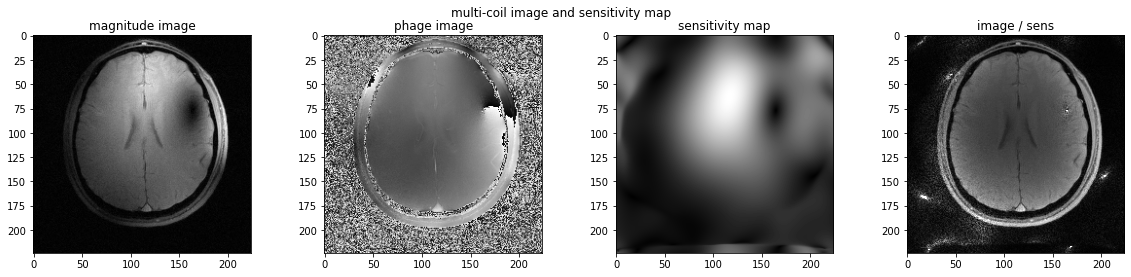

In [3]:
image_path = "./Data/Uncombined_data1/1.mat"
sens_path = "./Data/sensitivity1/1.mat"
init_rot = 10
motion_ran_lb = [0,0,0] #(offset, x-dif, y-dif)
motion_ran_ub = [0.5,0.5,0.5]
motion_PE_ran = [56, 224-56]
SNR_ran = [100,200]
img_size = [224, 224]
# batch_size = 100 -> unused

slice_no = 8 # 0 to 15
coil_no = 25 # 0 to 31

image = loadmat(image_path)['uncomb_img'][:,:,slice_no,0] # utilize the first echo
sens = loadmat(sens_path)['sensitivity'][:,:,slice_no,0]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle("multi-coil image and sensitivity map")
ax1.imshow(abs(image[:,:,coil_no]), cmap="gray")
ax1.set_title("magnitude image")
ax2.imshow(np.angle(image[:,:,coil_no]), cmap="gray")
ax2.set_title("phage image")
ax3.imshow(abs(sens[:,:,coil_no]), cmap="gray")
ax3.set_title("sensitivity map")
ax4.imshow(abs(image[:,:,coil_no]/sens[:,:,coil_no]), cmap="gray", vmin=0, vmax=1e-5)
ax4.set_title("image / sens")
fig.show()

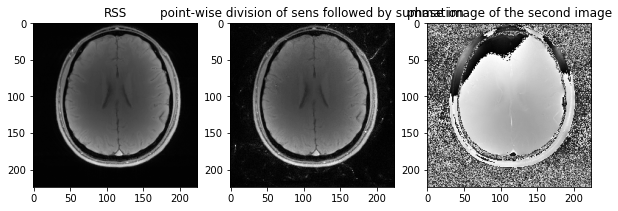

In [5]:
# how to DICOM-combine?

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(10)
rss = np.sqrt((abs(image)**2).sum(axis=-1))
ax1.imshow(rss, cmap="gray", vmin=0, vmax=1e-5)
ax1.set_title("RSS")
sens_div = abs((image/sens).sum(axis=-1))
ax2.imshow(sens_div, cmap="gray", vmin=0, vmax=3e-4)
ax2.set_title("point-wise division of sens followed by summation")
ax3.imshow(np.angle((image/sens).sum(axis=-1)), cmap="gray")
ax3.set_title("phase image of the second image")
fig.show()

In [9]:
from module.data_simulation import MotionParameters, SimulatedDataset

image_path = "./Data/Uncombined_data1/"
sens_path = "./Data/sensitivity1/"
init_rot = 0.0
motion_ran_lb = [0,0,0] #(offset, x-dif, y-dif)
motion_ran_ub = [0.01,0.01,0.01]
motion_PE_ran = [0, 32]
SNR_ran = [0,0]
img_size = [224, 224]

params = MotionParameters(img_size, SNR_ran, motion_ran_lb, motion_ran_ub, motion_PE_ran, rot=init_rot)
sim = SimulatedDataset(image_path, sens_path, params)

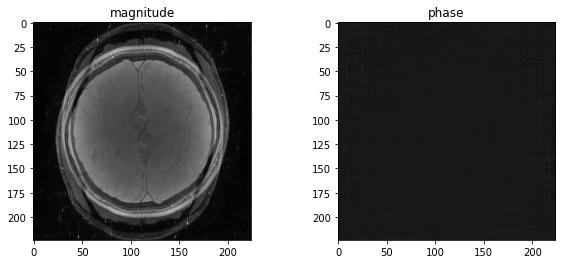

In [24]:
corrupted_k, pe = sim[0]
corrupted_k = torch.Tensor(corrupted_k)
corrupted = torch.fft.ifft2(corrupted_k)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
ax1.imshow(abs(corrupted), cmap="gray", vmin=0)
ax1.set_title("magnitude")
ax2.imshow(np.angle(corrupted), cmap="gray", vmax=5e-5)
ax2.set_title("phase")
fig.show()